# Shape Name Generation

In this notebook, we demonstrate the automated generation of meaningful shape names based on their visual appearance and the context in which they are embedded within a document.

A significant challenge in developing this approach was designing prompts and metadata in such a way that the model can reliably reason about design elements. These elements may be small, ambiguous in their appearance or visual structure, and present in documents with a high density of shapes.

We devised two different solutions:
- Using explicit visual annotations to guide the model
- A simplified approach with only two unannotated reference images and bounding boxes described in the prompt

This notebook focuses on the latter method, which is particularly suited for practical integration into Penpot.

In [1]:
%load_ext autoreload
%autoreload 2

from itertools import product

import matplotlib.pyplot as plt
from IPython.core.display import HTML, display
from tqdm.notebook import tqdm

from penai.llm.llm_model import RegisteredLLM
from penai.llm.utils import PromptVisualizer
from penai.registries.projects import SavedPenpotProject
from penai.registries.web_drivers import RegisteredWebDriver
from penai.render import WebDriverSVGRenderer
from penai.shape_name_generation.inference import (
    SimplifiedShapeNameGenerator,
)
from penai.utils.web_drivers import create_chrome_web_driver

plt.rcParams["figure.figsize"] = (14, 14)

/var/folders/_b/jrvj22sd3c709mpf5fsmty5h0000gn/T/ipykernel_45067/1278738917.py:4: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


## Single Example

We will first demonstrate the basic functionality using a single selected example to familiarize ourselves with the required classes, functions, and logic.

### Load Example Project

We will load the Material Design 3 project here, but feel free to choose a different one if preferred.

In [54]:
project = SavedPenpotProject.MATERIAL_DESIGN_3.load(pull=True)

Scanning remote paths in penpot/data/raw/designs/Material Design 3: 100%|██████████| 36/36 [00:00<00:00, 215.66it/s]
force pulling (bytes): 0it [00:00, ?it/s]


Let us investigate the project structure by printing the project object:

In [55]:
print(project)

Files: (name, id)
- Material Design 3 (3c46b0c9-0a64-80b8-8004-7546b11fafc1)
  Pages: (name, id)
  - Cover (3c46b0c9-0a64-80b8-8004-7546b1453d7d)
  - How it Works (3c46b0c9-0a64-80b8-8004-7546b1608c94)
  - Components & Variations (3c46b0c9-0a64-80b8-8004-7546b240409e)
  - Samples (3c46b0c9-0a64-80b8-8004-7546b7587ac4)
  - Versioning (3c46b0c9-0a64-80b8-8004-7546b7587ac5)
  - Main components (3c46b0c9-0a64-80b8-8004-7546b75cd4c3)
  - Page 1 (3c46b0c9-0a64-80b8-8004-7546bb300815)
  - Page 2 (3c46b0c9-0a64-80b8-8004-7546bb306911)
  - Page 3 (3c46b0c9-0a64-80b8-8004-7546bb306912)
  - Page 4 (3c46b0c9-0a64-80b8-8004-7546bb306913)
  - Page 5 (3c46b0c9-0a64-80b8-8004-7546bb306914)
  - Page 6 (3c46b0c9-0a64-80b8-8004-7546bb306915)
  - Page 7 (3c46b0c9-0a64-80b8-8004-7546bb306916)
  - Page 8 (3c46b0c9-0a64-80b8-8004-7546bb3086a1)
  Components: (name, id)
  Typographies: (name, id)
  - Label Large (3c46b0c9-0a64-80b8-8004-7546b149a54b)
  - Title Small (3c46b0c9-0a64-80b8-8004-7546b1505e57)
  - D

Select the cover page from the main file:

In [4]:
cover_page = project.get_main_file().get_page_by_name("Cover")

Design documents in Penpot are currently represented as SVGs. We use a web-based renderer to convert them into raster graphics. A web driver (Chrome) needs to be instantiated before a `WebDriverSVGRenderer` can be created:

In [5]:
web_driver = create_chrome_web_driver()
svg_renderer = WebDriverSVGRenderer(web_driver, infer_bounding_boxes=True)

Let us render the whole cover page for inspection:

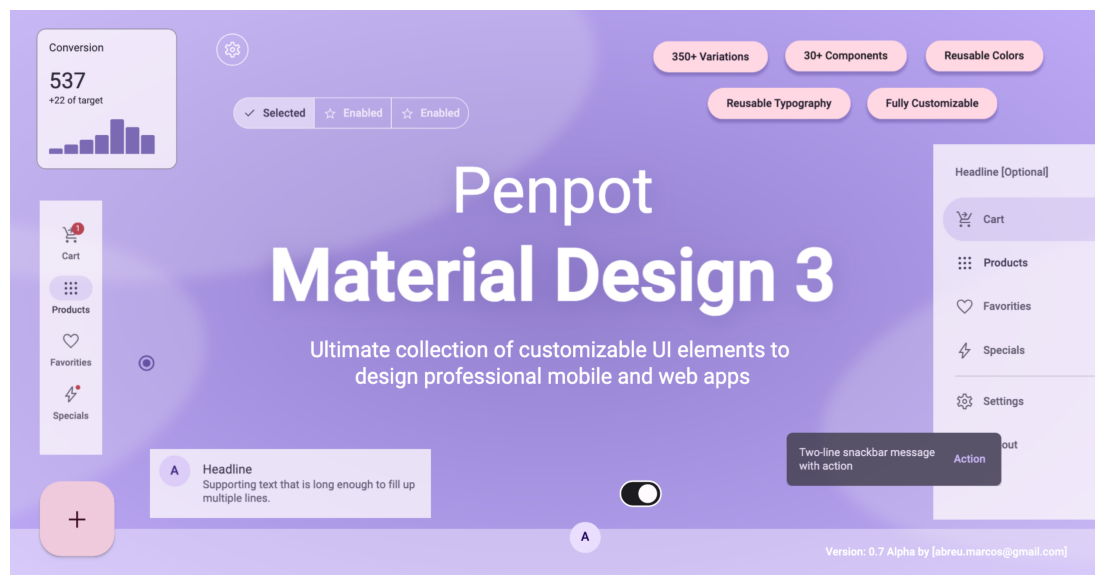

In [56]:
output = svg_renderer.render_svg(cover_page.svg, width=2000)

plt.imshow(output.image)
plt.axis("off")
plt.show()

We can now select a shape to generate a name. A good choice is the conversion card in the top-left corner. It is a frame or shape group, which the model should not confuse with its contained sub-elements.

For convenience, the shape will be queried by its name in the following steps. However, this name will not influence the naming process later on.

In [57]:
shape = cover_page.svg.get_shape_by_name("Card / Layout / Graph Outlined Card")

Note that the `WebDriverSVGRenderer` has been created with `infer_bounding_boxes=True`. As a by-product of the SVG rendering, the browser also computes bounding boxes for each SVG element. With this option set to `True`, we can query these bounding boxes, which will be useful for further processing.

To inspect a bounding box, simply index `output.artifacts.bounding_boxes` using the shape ID:

In [58]:
shape_bbox = output.artifacts.bounding_boxes[shape.shape_id]

In [59]:
print(shape_bbox)

BoundingBox(x=48.92804718017578, y=35.970951080322266, width=258.9908447265625, height=258.9908447265625)


This bounding box can, for instance, now be used to crop the shape to be named from within the full page image:

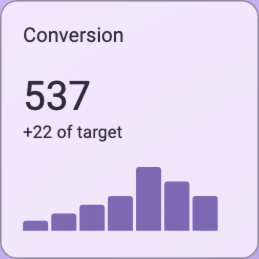

In [60]:
shape_bbox.crop_image(output.image)

### Generate Shape Names

The core functionality for generating shape names is implemented in the `penai.shape_name_generation.inference.SimplifiedShapeNameGenerator` class. In summary, it performs the following steps to generate a shape name:

1. **Derive the top-level frame of a shape:** Pages in Penpot are typically organized into different design groups with frames. Since providing the context of an entire page to the model isn't practical, the top-level frame of a shape is used as the "context limit."
2. **Render reference images:** The top-level frame is rendered, and the shape to be named is cropped. This provides sufficient visual context for the model while requiring only one rendering pass.
3. **Construct the prompt:** The prompt contains the two reference images and additional metadata in text form. We will take a closer look at this step shortly.
4. **Extract the name from the output:** The model is instructed to provide the output in JSON format. However, for models that don't fully support JSON output, additional logic is applied to extract the name from potentially malformed outputs.

In [62]:
# Feel free to experiment with different options here
name_generator = SimplifiedShapeNameGenerator(
    svg_renderer, RegisteredLLM.GPT4O,
    use_json_mode=True,
    include_coordinates=True
)

We can now generate a shape name. Normally, the `generate_name()` method is recommended for use, but the underlying `generate_name_impl()` provides the metadata from the prompt, which is useful for understanding the approach in this case.

In [63]:
output = name_generator.generate_name_impl(shape)

Before revealing the generated name, let’s take a closer look at the prompt. It consists of a single "Human" message, with no "System" or "AI" prompt. While well-crafted system prompts can often improve model behavior, finding the right formulation can be challenging. In our tests, a simple human message has proven to be sufficient.

Also note the inclusion of bounding box coordinates, the shape type, the output format specification, and a few example names to guide the model in generating the desired naming format. These examples can be modified if a different naming style is preferred or even derived from previous user choices.


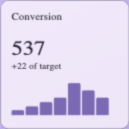
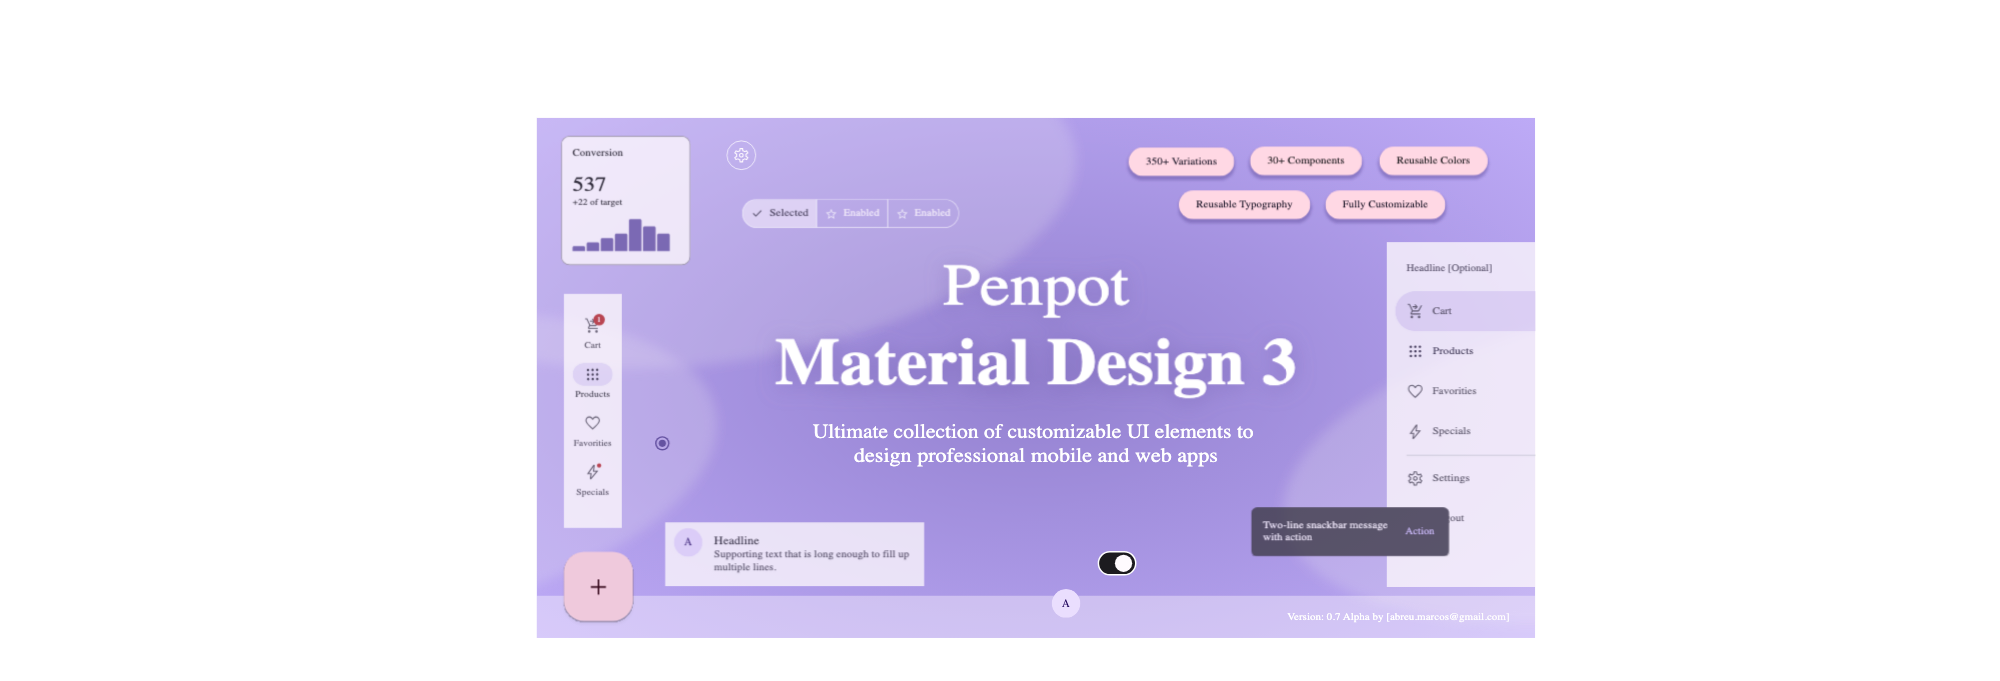

In [66]:
prompt_visualizer = PromptVisualizer()

display(HTML(prompt_visualizer.visualize_messages(output.messages)))

### The generated name:

In [67]:
output.name

'Conversion Card'

### Comparing Different Models and Configurations

We can run the name generation process for different models, with or without including bounding box information. Interestingly, for this specific example, the naming appears to be fairly consistent across models.

Executing all generations may take some time. Although LLM requests could theoretically be parallelized, doing so would require a mutex mechanism for the underlying web driver-based SVG renderer.

Note that we are using a sampling temperature of 0 here, meaning the results for a given prompt will be deterministic. An example of non-deterministic random sampling is provided later on.

In [68]:
models = [
    RegisteredLLM.GPT4O,
    RegisteredLLM.GPT4O_MINI,
    RegisteredLLM.CLAUDE_3_5_SONNET,
    RegisteredLLM.GEMINI_1_5_PRO,
    RegisteredLLM.GEMINI_1_5_FLASH,
]

include_coordinates_choices = [True, False]

results = []

with tqdm(total=len(models) * len(include_coordinates_choices)) as pbar:
    for model, include_coordinates in product(models, include_coordinates_choices):
        pbar.set_description(
            f"model={model.name}, include_coordinates={include_coordinates}"
        )
        name_generator = SimplifiedShapeNameGenerator(
            svg_renderer,
            model,
            use_json_mode=False,
            include_coordinates=include_coordinates,
        )

        output = name_generator.generate_name_impl(shape)

        results.append((model, include_coordinates, output))

        pbar.update(1)

  0%|          | 0/10 [00:00<?, ?it/s]

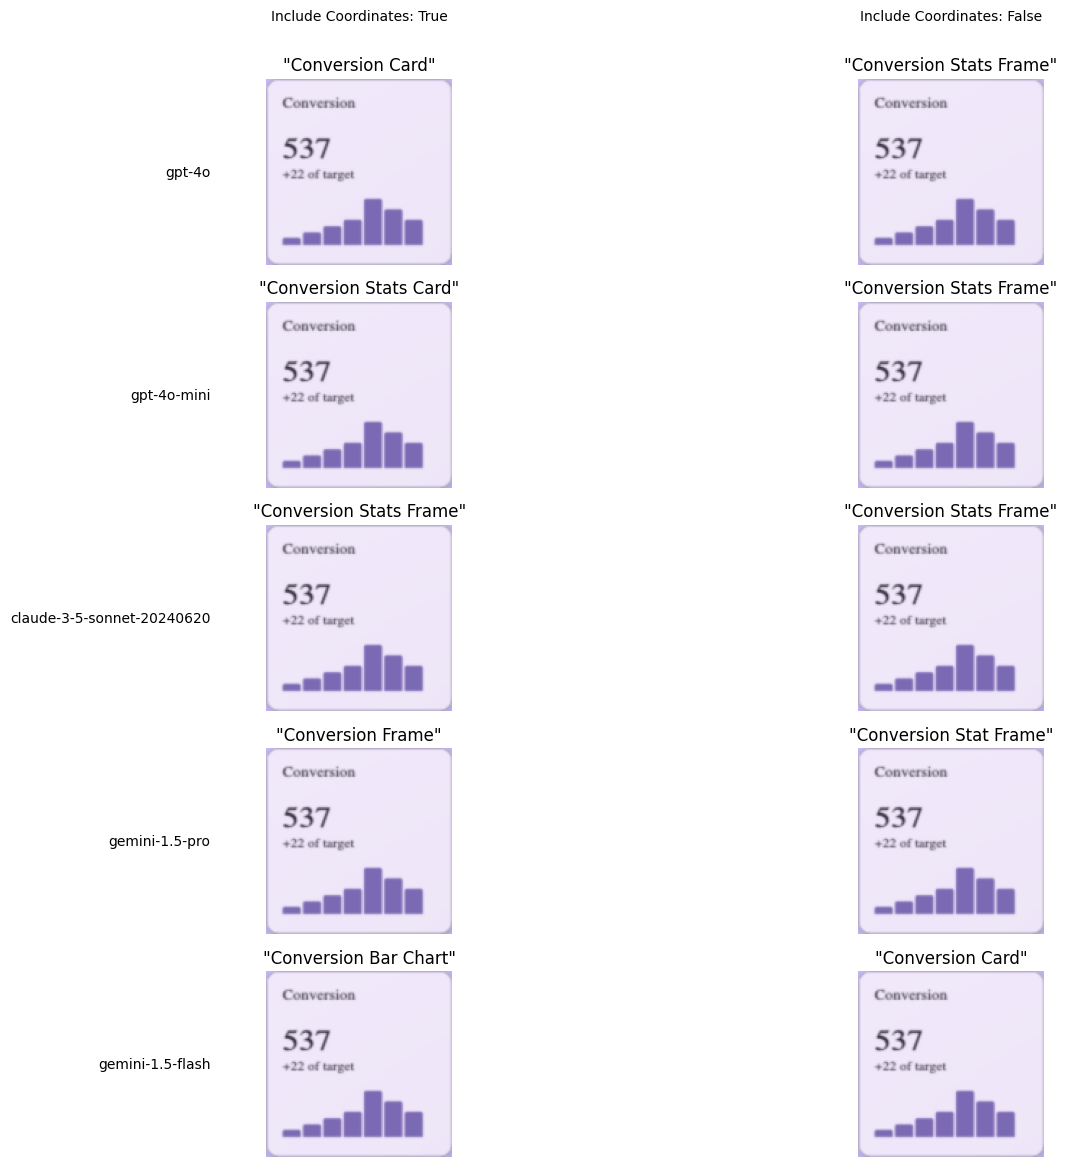

In [70]:
models = [
    RegisteredLLM.GPT4O,
    RegisteredLLM.GPT4O_MINI,
    RegisteredLLM.CLAUDE_3_5_SONNET,
    RegisteredLLM.GEMINI_1_5_PRO,
    RegisteredLLM.GEMINI_1_5_FLASH,
]

include_coordinates_choices = [True, False]

fig, axes = plt.subplots(
    len(models), len(include_coordinates_choices), figsize=(14, 14)
)

idx = 0

for row_idx, (row_axes, model) in enumerate(zip(axes, models, strict=True)):
    for col_idx, (ax, include_coordinates) in enumerate(
        zip(row_axes, include_coordinates_choices, strict=True)
    ):
        if row_idx == 0:
            ax.text(
                0.5,
                1.3,
                f"Include Coordinates: {include_coordinates}",
                horizontalalignment="center",
                verticalalignment="bottom",
                transform=ax.transAxes,
            )

        if col_idx == 0:
            ax.text(
                -0.3,
                0.5,
                model.value,
                horizontalalignment="right",
                verticalalignment="center",
                transform=ax.transAxes,
            )

        _, _, output = results[idx]

        ax.imshow(output.shape_image)
        ax.axis("off")
        ax.set_title(f"\"{output.name}\"")
        idx += 1

### Random Sampling of Names

To obtain a potentially different name with each request, the sampling temperature, provided as a keyword argument to the `SimplifiedShapeNameGenerator` constructor, can be set to greater than 0. Values between 0.7 and 1.3 are typically good choices. Higher values result in more uniform token sampling, leading to greater "diversity," while a value of 0 is equivalent to selecting the most likely word (argmax) for each prediction.

Once again, the execution could be parallelized, or multiple name suggestions could be generated within the initial prompt.

In [73]:
num_samples = 10

names = []

for _ in tqdm(range(num_samples)):
    name_generator = SimplifiedShapeNameGenerator(
        svg_renderer,
        RegisteredLLM.GPT4O,
        use_json_mode=False,
        include_coordinates=include_coordinates,
        temperature=1.3,
    )
    names.append(name_generator.generate_name(shape))

  0%|          | 0/10 [00:00<?, ?it/s]

In [77]:
names

['Conversion_Summary_Card',
 'Conversion Data Tile',
 'Conversion Metric Card',
 'Conversion Stats Frame',
 'Conversion Metric Card',
 'Conversion Widget Frame',
 'Conversion Stat Card',
 'Conversion Frame',
 'Conversion Chart Frame',
 'Conversion Stats Card']

# Systematic Evaluation

A set of selected shapes from multiple design documents and pages is provided in the `test/resources/evaluation_data.json` file. This dataset includes relatively straightforward cases, such as conversion boxes, as well as more challenging ones, like small icons or intersecting non-rectangular path elements.

Let’s evaluate how well the approach performs on these examples.

In [74]:
import json
import os
from pathlib import Path

from penai.config import get_config
from penai.models import PenpotProject

In [75]:
cfg = get_config()

In [76]:
eval_data = json.loads(Path("../test/resources/evaluation_data.json").read_text())

**Note:** Executing the cell below may take up to 10 minutes as preprocessing and name generation will be performed on dozens of shapes.

In [52]:
generated_names = {}

num_pages = 0
max_shapes_per_page = 0

name_generator = SimplifiedShapeNameGenerator(
    svg_renderer,
    RegisteredLLM.CLAUDE_3_5_SONNET,
    use_json_mode=True,
    include_coordinates=True,
)

for project_dir, project_data in eval_data.items():
    project_path = os.path.join(get_config().penpot_designs_basedir(), project_dir)
    project = PenpotProject.from_directory(project_path)

    main_file = project.get_main_file()

    for page_name, page_data in project_data.items():
        page = main_file.get_page_by_name(page_name)

        page_svg = page.svg
        page_svg.remove_elements_with_no_visible_content()
        page_svg.retrieve_and_set_view_boxes_for_shape_elements()

        for shape_id in page_data["shapes"]:
            shape = page_svg.get_shape_by_id(shape_id)

            generated_names[shape_id] = name_generator.generate_name_impl(shape)

        num_pages += 1
        max_shapes_per_page = max(max_shapes_per_page, len(page_data["shapes"]))

Setting view boxes: 100%|██████████| 526/526 [00:03<00:00, 166.83it/s]


## Visualize results

/var/folders/_b/jrvj22sd3c709mpf5fsmty5h0000gn/T/ipykernel_45067/625204326.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


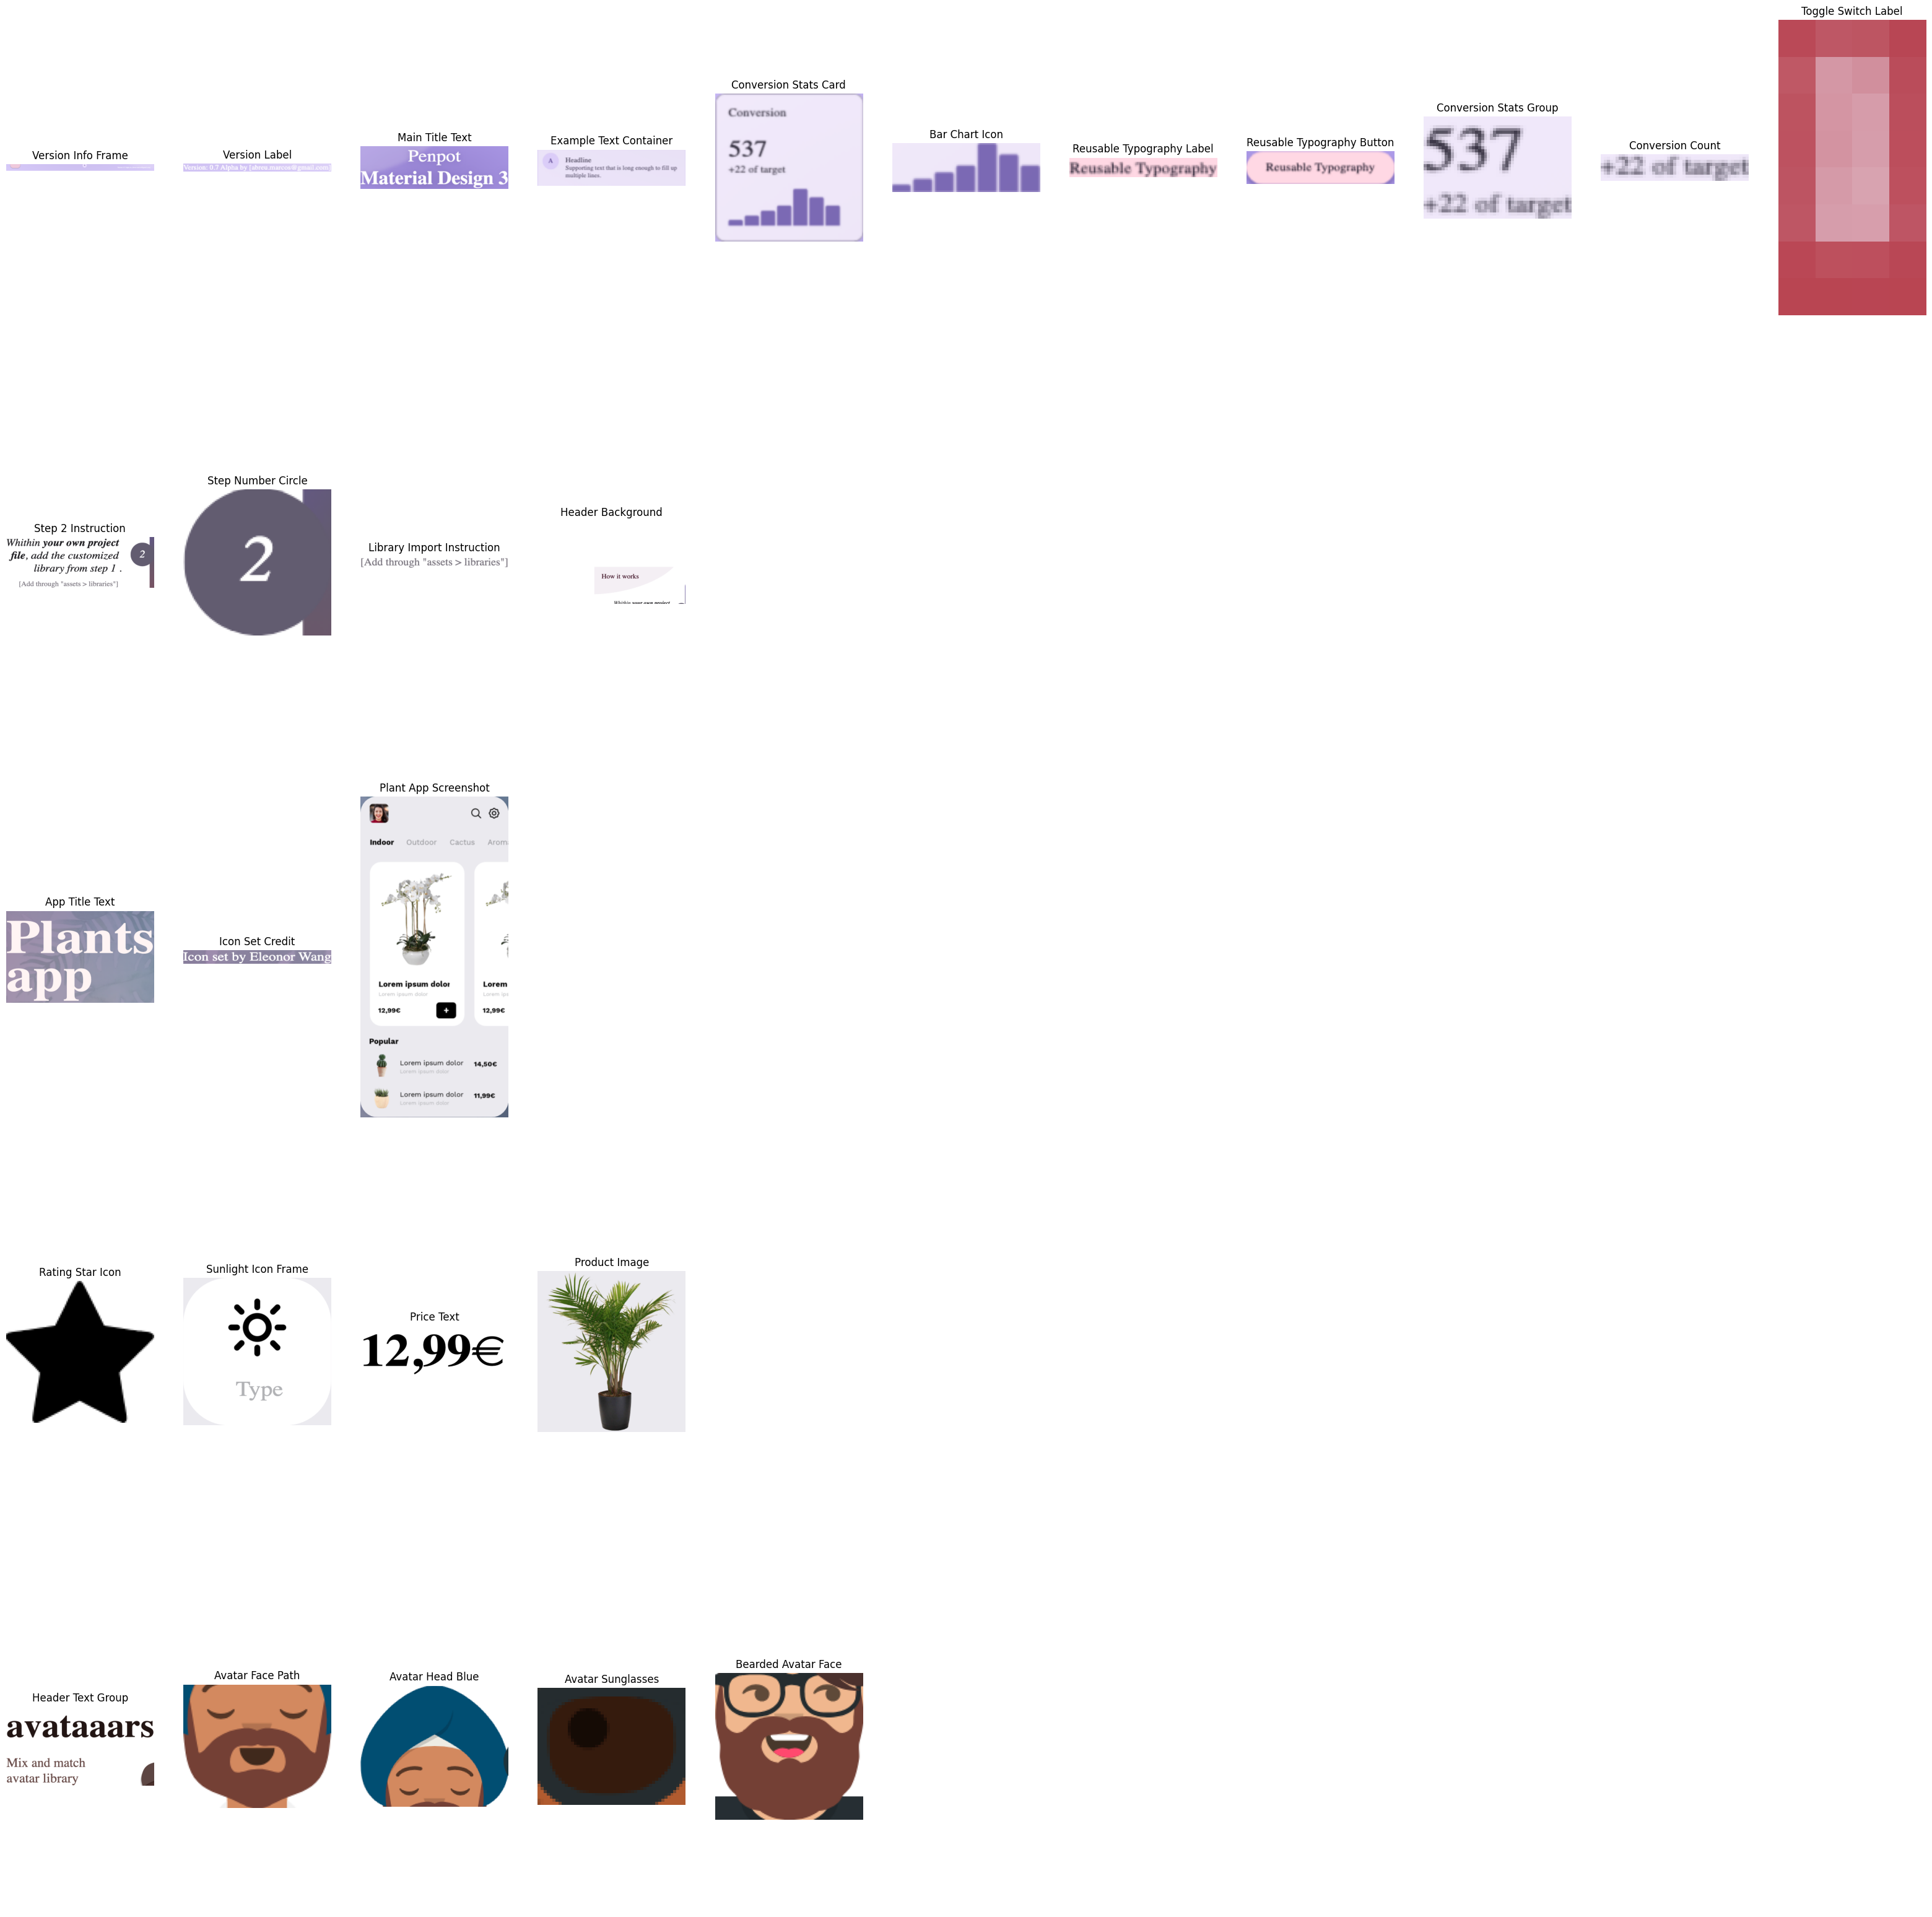

In [53]:
fig, axes = plt.subplots(num_pages, max_shapes_per_page, figsize=(40, 40))

if num_pages == 1:
    axes = [axes]

row_idx = 0

for project_dir, project_data in eval_data.items():
    project_path = os.path.join(get_config().penpot_designs_basedir(), project_dir)
    project = PenpotProject.from_directory(project_path)

    main_file = project.get_main_file()

    for page_name, page_data in project_data.items():
        row_axes = axes[row_idx]

        page_svg = main_file.get_page_by_name(page_name).svg

        for col_idx, shape_id in enumerate(page_data["shapes"]):
            shape = page_svg.get_shape_by_id(shape_id)
            generated_name = generated_names[shape_id]

            row_axes[col_idx].imshow(generated_name.shape_image)
            row_axes[col_idx].set_title(generated_name.name)

        for row_ax in row_axes:
            row_ax.axis("off")

        row_idx += 1

fig.show()

## Important: Close the Web Driver

For simplicity, we did not use a context manager in this notebook to automatically close the web driver after use. Therefore, it must be closed manually to prevent further resource consumption.

In [78]:
web_driver.close()